In [ ]:
# Transformers installation
! pip install transformers datasets evaluate accelerate
! pip install -q -U albumentations>=1.4.5 torchmetrics pycocotools
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


# Object detection

Object detection is the computer vision task of detecting instances (such as humans, buildings, or cars) in an image. Object detection models receive an image as input and output
coordinates of the bounding boxes and associated labels of the detected objects. An image can contain multiple objects,
each with its own bounding box and a label (e.g. it can have a car and a building), and each object can
be present in different parts of an image (e.g. the image can have several cars).
This task is commonly used in autonomous driving for detecting things like pedestrians, road signs, and traffic lights.
Other applications include counting objects in images, image search, and more.

In this guide, you will learn how to:

 1. Finetune [DETR](https://huggingface.co/docs/transformers/model_doc/detr), a model that combines a convolutional
 backbone with an encoder-decoder Transformer, on the [CPPE-5](https://huggingface.co/datasets/cppe-5)
 dataset.
 2. Use your finetuned model for inference.

<Tip>

To see all architectures and checkpoints compatible with this task, we recommend checking the [task-page](https://huggingface.co/tasks/object-detection)

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install -q datasets transformers accelerate timm
pip install -q -U albumentations>=1.4.5 torchmetrics pycocotools
```

You'll use 🤗 Datasets to load a dataset from the Hugging Face Hub, 🤗 Transformers to train your model,
and `albumentations` to augment the data.

We encourage you to share your model with the community. Log in to your Hugging Face account to upload it to the Hub.
When prompted, enter your token to log in:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

To get started, we'll define global constants, namely the model name and image size. For this tutorial, we'll use the conditional DETR model due to its faster convergence. Feel free to select any object detection model available in the `transformers` library.

In [ ]:
MODEL_NAME = "facebook/detr-resnet-50" # "microsoft/conditional-detr-resnet-50"  # or "facebook/detr-resnet-50"
IMAGE_SIZE = 480

## Load the CPPE-5 dataset

The [CPPE-5 dataset](https://huggingface.co/datasets/cppe-5) contains images with
annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic.

Start by loading the dataset and creating a `validation` split from `train`:

In [ ]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")

if "validation" not in cppe5:
    split = cppe5["train"].train_test_split(0.15, seed=1337)
    cppe5["train"] = split["train"]
    cppe5["validation"] = split["test"]

cppe5

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/4.14M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 850
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 150
    })
})

You'll see that this dataset has 1000 images for train and validation sets and a test set with 29 images.

To get familiar with the data, explore what the examples look like.

In [ ]:
cppe5["train"][0]

{'image_id': 366,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=500x290>,
 'width': 500,
 'height': 500,
 'objects': {'id': [1932, 1933, 1934],
  'area': [27063, 34200, 32431],
  'bbox': [[29.0, 11.0, 97.0, 279.0],
   [201.0, 1.0, 120.0, 285.0],
   [382.0, 0.0, 113.0, 287.0]],
  'category': [0, 0, 0]}}

The examples in the dataset have the following fields:
- `image_id`: the example image id
- `image`: a `PIL.Image.Image` object containing the image
- `width`: width of the image
- `height`: height of the image
- `objects`: a dictionary containing bounding box metadata for the objects in the image:
  - `id`: the annotation id
  - `area`: the area of the bounding box
  - `bbox`: the object's bounding box (in the [COCO format](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco) )
  - `category`: the object's category, with possible values including `Coverall (0)`, `Face_Shield (1)`, `Gloves (2)`, `Goggles (3)` and `Mask (4)`

You may notice that the `bbox` field follows the COCO format, which is the format that the DETR model expects.
However, the grouping of the fields inside `objects` differs from the annotation format DETR requires. You will
need to apply some preprocessing transformations before using this data for training.

To get an even better understanding of the data, visualize an example in the dataset.

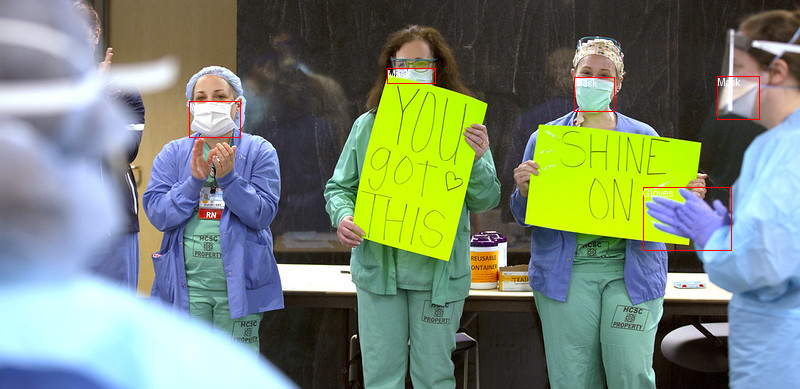

In [ ]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][2]["image"]
annotations = cppe5["train"][2]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"]["category"].feature.names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

<div class="flex justify-center">
    <img src="https://i.imgur.com/oVQb9SF.png" alt="CPPE-5 Image Example"/>
</div>


To visualize the bounding boxes with associated labels, you can get the labels from the dataset's metadata, specifically
the `category` field.
You'll also want to create dictionaries that map a label id to a label class (`id2label`) and the other way around (`label2id`).
You can use them later when setting up the model. Including these maps will make your model reusable by others if you share
it on the Hugging Face Hub. Please note that, the part of above code that draws the bounding boxes assume that it is in `COCO` format `(x_min, y_min, width, height)`. It has to be adjusted to work for other formats like `(x_min, y_min, x_max, y_max)`.

As a final step of getting familiar with the data, explore it for potential issues. One common problem with datasets for
object detection is bounding boxes that "stretch" beyond the edge of the image. Such "runaway" bounding boxes can raise
errors during training and should be addressed. There are a few examples with this issue in this dataset.
To keep things simple in this guide, we will set `clip=True` for `BboxParams` in transformations below.

## Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model.
[AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and
`labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial
to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [ ]:
from transformers import AutoImageProcessor

MAX_SIZE = IMAGE_SIZE

image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},
    do_pad=True,
    pad_size={"height": MAX_SIZE, "width": MAX_SIZE},
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Before passing the images to the `image_processor`, apply two preprocessing transformations to the dataset:
- Augmenting images
- Reformatting annotations to meet DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/).
This library ensures that transformations affect the image and update the bounding boxes accordingly.
The 🤗 Datasets library documentation has a detailed [guide on how to augment images for object detection](https://huggingface.co/docs/datasets/object_detection),
and it uses the exact same dataset as an example. Apply some geometric and color transformations to the image. For additional augmentation options, explore the [Albumentations Demo Space](https://huggingface.co/spaces/qubvel-hf/albumentations-demo).

In [ ]:
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, filter_invalid_bboxes=True),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

The `image_processor` expects the annotations to be in the following format: `{'image_id': int, 'annotations': list[Dict]}`,
 where each dictionary is a COCO object annotation. Let's add a function to reformat annotations for a single example:

In [ ]:
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (list[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (list[float]): list of corresponding areas to provided bounding boxes
        bboxes (list[tuple[float]]): list of bounding boxes provided in COCO format
            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }

Now you can combine the image and annotation transformations to use on a batch of examples:

In [ ]:
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations
        output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(output["image"])

        # format annotations in COCO format
        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

Apply this preprocessing function to the entire dataset using 🤗 Datasets [with_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.with_transform) method. This method applies
transformations on the fly when you load an element of the dataset.

At this point, you can check what an example from the dataset looks like after the transformations. You should see a tensor
with `pixel_values`, a tensor with `pixel_mask`, and `labels`.

In [ ]:
from functools import partial

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

cppe5["train"] = cppe5["train"].with_transform(train_transform_batch)
cppe5["validation"] = cppe5["validation"].with_transform(validation_transform_batch)
cppe5["test"] = cppe5["test"].with_transform(validation_transform_batch)

cppe5["train"][15]

{'pixel_values': tensor([[[-0.8507, -0.9020, -0.9534,  ...,  1.3927,  1.3584,  1.3413],
          [-0.8849, -0.9363, -0.9877,  ...,  1.4098,  1.3927,  1.3755],
          [-0.9363, -0.9705, -1.0219,  ...,  1.4440,  1.4269,  1.4269],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.5903,  0.4678,  0.3452,  ...,  1.5532,  1.5182,  1.5007],
          [ 0.5553,  0.4503,  0.3102,  ...,  1.5707,  1.5532,  1.5357],
          [ 0.5203,  0.4153,  0.2752,  ...,  1.6057,  1.5882,  1.5882],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.0964, -0.1661, -0.2358,  ...,  1.7685,  1.7337,  1.7163],
          [-

You have successfully augmented the individual images and prepared their annotations. However, preprocessing isn't
complete yet. In the final step, create a custom `collate_fn` to batch images together.
Pad images (which are now `pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask`
to indicate which pixels are real (1) and which are padding (0).

In [ ]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data

## Preparing function to compute mAP

Object detection models are commonly evaluated with a set of <a href="https://cocodataset.org/#detection-eval">COCO-style metrics</a>. We are going to use `torchmetrics` to compute `mAP` (mean average precision) and `mAR` (mean average recall) metrics and will wrap it to `compute_metrics` function in order to use in [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) for evaluation.

Intermediate format of boxes used for training is `YOLO` (normalized) but we will compute metrics for boxes in `Pascal VOC` (absolute) format in order to correctly handle box areas. Let's define a function that converts bounding boxes to `Pascal VOC` format:

In [ ]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

Then, in `compute_metrics` function we collect `predicted` and `target` bounding boxes, scores and labels from evaluation loop results and pass it to the scoring function.

In [ ]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

## Training the detection model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model!
The images in this dataset are still quite large, even after resizing. This means that finetuning this model will
require at least one GPU.

Training involves the following steps:
1. Load the model with [AutoModelForObjectDetection](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
2. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
3. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
4. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id`
and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

In [ ]:
num_param = sum(p.numel() for p in model.parameters()) / 1e6
print(f"Number of parameters: {num_param}")

Number of parameters: 41.502666


In [ ]:
print(model)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [ ]:
for p in model.parameters():
    p.requires_grad = False
for name, child in model.named_children():
  if "class_labels_classifier" in name or "bbox_predictor" in name:
    for param in child.parameters():
      param.requires_grad = True

In [ ]:
num_param = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(f"Number of parameters: {num_param}")

Number of parameters: 0.134154


In [ ]:
import torch.nn as nn


class LoRAConv2d(nn.Module):
  def __init__(self, conv, r, scale):
    super().__init__()
    self.conv = conv
    self.scale = scale
    cout, cin, k, k = conv.weight.shape
    self.lora_a = nn.Parameter(torch.Tensor(cin * k, r * k))
    self.lora_b = nn.Parameter(torch.Tensor(r * k, cout * k))
    nn.init.kaiming_uniform_(self.lora_a)
    nn.init.zeros_(self.lora_b)

  def forward(self, x):
    deltaW = self.scale * self.lora_a @ self.lora_b
    deltaW = deltaW.view(self.conv.weight.shape)
    return self.conv._conv_forward(x, self.conv.weight + deltaW, self.conv.bias)


def inject_LoRAC(model, r=4, scale=1.0):
  for name, child in model.named_children():
    if isinstance(child, nn.Conv2d):
      setattr(model, name, LoRAConv2d(child, r, scale))
    else:
      inject_LoRAC(child, r, scale)

In [ ]:
inject_LoRAC(model, r=8, scale=1.0)
num_param = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(f"Number of parameters: {num_param}")

Number of parameters: 1.05437


In [ ]:
print(model)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): LoRAConv2d(
            (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          )
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): LoRAConv2d(
                (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              )
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): LoRAConv2d(
                (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              )
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (a

In [ ]:
class DoRALinear(nn.Module):
  def __init__(self, linear: nn.Linear, r, dropout, scale):
    super().__init__()
    self.linear = linear
    self.dropout = nn.Dropout(p=dropout)
    self.scale = scale
    k, d = linear.weight.shape
    self.lora_a = nn.Parameter(torch.Tensor(d, r))
    self.lora_b = nn.Parameter(torch.Tensor(r, k))
    nn.init.zeros_(self.lora_b)
    nn.init.kaiming_uniform_(self.lora_a)
    self.m = nn.Parameter(torch.Tensor(k))
    with torch.no_grad():
      self.m.copy_(torch.linalg.norm(linear.weight, dim=1))

  def forward(self, x):
    y = x @ self.linear.weight.T
    x = self.dropout(x)

    deltaV = self.scale * self.lora_a @ self.lora_b
    z = x @ deltaV
    Vprime = self.linear.weight.T + deltaV.detach() # d x k
    cNorm = torch.linalg.norm(Vprime.T, dim=1)
    cNorm = cNorm.detach()
    out = (self.m / cNorm) * (y + z)
    if self.linear.bias is not None:
      out = out + self.linear.bias
    return out


def inject_DoRA(model, r=16, dropout=0.0, scale=1.0):
  for name, child in model.named_children():
    if isinstance(child, nn.Linear):
      if "q_proj" in name or "k_proj" in name or "v_proj" in name or "out_proj" in name:
        setattr(model, name, DoRALinear(child, r, dropout, scale))
    else:
      inject_DoRA(child, r, dropout, scale)

In [ ]:
inject_DoRA(model, r = 16, dropout=0.0, scale=8.0)
num_param = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(f"Number of parameters: {num_param}")

Number of parameters: 1.662626


In [ ]:
print(model)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): LoRAConv2d(
            (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          )
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): LoRAConv2d(
                (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              )
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): LoRAConv2d(
                (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              )
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (a

In the [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit. For `num_train_epochs=30` training will take about 35 minutes in Google Colab T4 GPU, increase the number of epoch to get better results.

Important notes:
 - Do not remove unused columns because this will drop the image column. Without the image column, you
can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`.
 - Set `eval_do_concat_batches=False` to get proper evaluation results. Images have different number of target boxes, if batches are concatenated we will not be able to determine which boxes belongs to particular image.

If you wish to share your model by pushing to the Hub, set `push_to_hub` to `True` (you must be signed in to Hugging
Face to upload your model).

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    #output_dir="detr_finetuned_cppe5",
    num_train_epochs=30,
    fp16=False,
    per_device_train_batch_size=8,
    dataloader_num_workers=2,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    #push_to_hub=True,
    report_to="none"
)

Finally, bring everything together, and call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cppe5["train"],
    eval_dataset=cppe5["validation"],
    processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Coverall,Mar 100 Coverall,Map Face Shield,Mar 100 Face Shield,Map Gloves,Mar 100 Gloves,Map Goggles,Mar 100 Goggles,Map Mask,Mar 100 Mask
1,No log,2.576326,0.024200,0.065700,0.013700,0.000600,0.013600,0.026600,0.045400,0.107800,0.134300,0.019200,0.097600,0.146500,0.117300,0.494600,0.000000,0.000000,0.001500,0.064700,0.000000,0.000000,0.002300,0.112000
2,No log,2.207501,0.042300,0.092300,0.033500,0.002100,0.033900,0.046600,0.062600,0.136400,0.170600,0.043800,0.128700,0.192400,0.193000,0.534700,0.000000,0.000000,0.007000,0.151800,0.000000,0.000000,0.011200,0.166700
3,No log,2.189037,0.058200,0.128500,0.047400,0.002600,0.033000,0.064800,0.070500,0.146300,0.171700,0.033200,0.121600,0.215500,0.263900,0.561300,0.000000,0.000000,0.007900,0.143700,0.000000,0.000000,0.019100,0.153300
4,No log,2.024463,0.072500,0.156200,0.057500,0.004600,0.049800,0.079700,0.081900,0.178300,0.201200,0.044200,0.160100,0.248000,0.317400,0.593200,0.005500,0.043000,0.012400,0.159800,0.000000,0.000000,0.027100,0.209800
5,2.097200,1.963436,0.077200,0.177300,0.058100,0.023200,0.048700,0.090000,0.096200,0.203600,0.229800,0.080500,0.176100,0.279000,0.309900,0.590100,0.033400,0.110100,0.012100,0.213400,0.000000,0.000000,0.030700,0.235600
6,2.097200,2.036210,0.085300,0.183000,0.074400,0.007400,0.059500,0.104400,0.096200,0.189400,0.218600,0.060500,0.168300,0.276500,0.359700,0.603600,0.017200,0.077200,0.012700,0.197300,0.000000,0.000000,0.036800,0.214700
7,2.097200,1.943451,0.101000,0.213500,0.085300,0.020500,0.063800,0.130400,0.121100,0.238900,0.256800,0.086300,0.188200,0.343000,0.398700,0.606300,0.045200,0.220300,0.012500,0.180800,0.001800,0.033800,0.046800,0.242700
8,2.097200,1.907690,0.100200,0.229100,0.077300,0.029900,0.073700,0.118500,0.128500,0.247700,0.269400,0.108900,0.211000,0.374300,0.351200,0.569400,0.057900,0.226600,0.019600,0.208000,0.003000,0.050800,0.069200,0.292000
9,2.097200,1.848776,0.105200,0.225000,0.086300,0.037300,0.069700,0.139400,0.139500,0.275000,0.298300,0.114700,0.240900,0.394800,0.390100,0.599500,0.042300,0.293700,0.023000,0.237500,0.003500,0.084600,0.066900,0.276000
10,1.725200,1.791370,0.105500,0.243000,0.076300,0.023000,0.078600,0.136700,0.138200,0.285800,0.310100,0.085700,0.245700,0.449000,0.380700,0.599500,0.046200,0.291100,0.031000,0.286200,0.012400,0.100000,0.057300,0.273800


TrainOutput(global_step=3210, training_loss=1.5521397575782467, metrics={'train_runtime': 2723.4977, 'train_samples_per_second': 9.363, 'train_steps_per_second': 1.179, 'total_flos': 4.5479904634368e+18, 'train_loss': 1.5521397575782467, 'epoch': 30.0})

<div>

  <progress value='3210' max='3210' style='width:300px; height:20px; vertical-align: middle;'></progress>
  [3210/3210 26:07, Epoch 30/30]
</div>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th>Epoch</th>
      <th>Training Loss</th>
      <th>Validation Loss</th>
      <th>Map</th>
      <th>Map 50</th>
      <th>Map 75</th>
      <th>Map Small</th>
      <th>Map Medium</th>
      <th>Map Large</th>
      <th>Mar 1</th>
      <th>Mar 10</th>
      <th>Mar 100</th>
      <th>Mar Small</th>
      <th>Mar Medium</th>
      <th>Mar Large</th>
      <th>Map Coverall</th>
      <th>Mar 100 Coverall</th>
      <th>Map Face Shield</th>
      <th>Mar 100 Face Shield</th>
      <th>Map Gloves</th>
      <th>Mar 100 Gloves</th>
      <th>Map Goggles</th>
      <th>Mar 100 Goggles</th>
      <th>Map Mask</th>
      <th>Mar 100 Mask</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>No log</td>
      <td>2.629903</td>
      <td>0.008900</td>
      <td>0.023200</td>
      <td>0.006500</td>
      <td>0.001300</td>
      <td>0.002800</td>
      <td>0.020500</td>
      <td>0.021500</td>
      <td>0.070400</td>
      <td>0.101400</td>
      <td>0.007600</td>
      <td>0.106200</td>
      <td>0.096100</td>
      <td>0.036700</td>
      <td>0.232000</td>
      <td>0.000300</td>
      <td>0.019000</td>
      <td>0.003900</td>
      <td>0.125400</td>
      <td>0.000100</td>
      <td>0.003100</td>
      <td>0.003500</td>
      <td>0.127600</td>
    </tr>
    <tr>
      <td>2</td>
      <td>No log</td>
      <td>3.479864</td>
      <td>0.014800</td>
      <td>0.034600</td>
      <td>0.010800</td>
      <td>0.008600</td>
      <td>0.011700</td>
      <td>0.012500</td>
      <td>0.041100</td>
      <td>0.098700</td>
      <td>0.130000</td>
      <td>0.056000</td>
      <td>0.062200</td>
      <td>0.111900</td>
      <td>0.053500</td>
      <td>0.447300</td>
      <td>0.010600</td>
      <td>0.100000</td>
      <td>0.000200</td>
      <td>0.022800</td>
      <td>0.000100</td>
      <td>0.015400</td>
      <td>0.009700</td>
      <td>0.064400</td>
    </tr>
    <tr>
      <td>3</td>
      <td>No log</td>
      <td>2.107622</td>
      <td>0.041700</td>
      <td>0.094000</td>
      <td>0.034300</td>
      <td>0.024100</td>
      <td>0.026400</td>
      <td>0.047400</td>
      <td>0.091500</td>
      <td>0.182800</td>
      <td>0.225800</td>
      <td>0.087200</td>
      <td>0.199400</td>
      <td>0.210600</td>
      <td>0.150900</td>
      <td>0.571200</td>
      <td>0.017300</td>
      <td>0.101300</td>
      <td>0.007300</td>
      <td>0.180400</td>
      <td>0.002100</td>
      <td>0.026200</td>
      <td>0.031000</td>
      <td>0.250200</td>
    </tr>
    <tr>
      <td>4</td>
      <td>No log</td>
      <td>2.031242</td>
      <td>0.055900</td>
      <td>0.120600</td>
      <td>0.046900</td>
      <td>0.013800</td>
      <td>0.038100</td>
      <td>0.090300</td>
      <td>0.105900</td>
      <td>0.225600</td>
      <td>0.266100</td>
      <td>0.130200</td>
      <td>0.228100</td>
      <td>0.330000</td>
      <td>0.191000</td>
      <td>0.572100</td>
      <td>0.010600</td>
      <td>0.157000</td>
      <td>0.014600</td>
      <td>0.235300</td>
      <td>0.001700</td>
      <td>0.052300</td>
      <td>0.061800</td>
      <td>0.313800</td>
    </tr>
    <tr>
      <td>5</td>
      <td>3.889400</td>
      <td>1.883433</td>
      <td>0.089700</td>
      <td>0.201800</td>
      <td>0.067300</td>
      <td>0.022800</td>
      <td>0.065300</td>
      <td>0.129500</td>
      <td>0.136000</td>
      <td>0.272200</td>
      <td>0.303700</td>
      <td>0.112900</td>
      <td>0.312500</td>
      <td>0.424600</td>
      <td>0.300200</td>
      <td>0.585100</td>
      <td>0.032700</td>
      <td>0.202500</td>
      <td>0.031300</td>
      <td>0.271000</td>
      <td>0.008700</td>
      <td>0.126200</td>
      <td>0.075500</td>
      <td>0.333800</td>
    </tr>
    <tr>
      <td>6</td>
      <td>3.889400</td>
      <td>1.807503</td>
      <td>0.118500</td>
      <td>0.270900</td>
      <td>0.090200</td>
      <td>0.034900</td>
      <td>0.076700</td>
      <td>0.152500</td>
      <td>0.146100</td>
      <td>0.297800</td>
      <td>0.325400</td>
      <td>0.171700</td>
      <td>0.283700</td>
      <td>0.545900</td>
      <td>0.396900</td>
      <td>0.554500</td>
      <td>0.043000</td>
      <td>0.262000</td>
      <td>0.054500</td>
      <td>0.271900</td>
      <td>0.020300</td>
      <td>0.230800</td>
      <td>0.077600</td>
      <td>0.308000</td>
    </tr>
    <tr>
      <td>7</td>
      <td>3.889400</td>
      <td>1.716169</td>
      <td>0.143500</td>
      <td>0.307700</td>
      <td>0.123200</td>
      <td>0.045800</td>
      <td>0.097800</td>
      <td>0.258300</td>
      <td>0.165300</td>
      <td>0.327700</td>
      <td>0.352600</td>
      <td>0.140900</td>
      <td>0.336700</td>
      <td>0.599400</td>
      <td>0.442900</td>
      <td>0.620700</td>
      <td>0.069400</td>
      <td>0.301300</td>
      <td>0.081600</td>
      <td>0.292000</td>
      <td>0.011000</td>
      <td>0.230800</td>
      <td>0.112700</td>
      <td>0.318200</td>
    </tr>
    <tr>
      <td>8</td>
      <td>3.889400</td>
      <td>1.679014</td>
      <td>0.153000</td>
      <td>0.355800</td>
      <td>0.127900</td>
      <td>0.038700</td>
      <td>0.115600</td>
      <td>0.291600</td>
      <td>0.176000</td>
      <td>0.322500</td>
      <td>0.349700</td>
      <td>0.135600</td>
      <td>0.326100</td>
      <td>0.643700</td>
      <td>0.431700</td>
      <td>0.582900</td>
      <td>0.069800</td>
      <td>0.265800</td>
      <td>0.088600</td>
      <td>0.274600</td>
      <td>0.028300</td>
      <td>0.280000</td>
      <td>0.146700</td>
      <td>0.345300</td>
    </tr>
    <tr>
      <td>9</td>
      <td>3.889400</td>
      <td>1.618239</td>
      <td>0.172100</td>
      <td>0.375300</td>
      <td>0.137600</td>
      <td>0.046100</td>
      <td>0.141700</td>
      <td>0.308500</td>
      <td>0.194000</td>
      <td>0.356200</td>
      <td>0.386200</td>
      <td>0.162400</td>
      <td>0.359200</td>
      <td>0.677700</td>
      <td>0.469800</td>
      <td>0.623900</td>
      <td>0.102100</td>
      <td>0.317700</td>
      <td>0.099100</td>
      <td>0.290200</td>
      <td>0.029300</td>
      <td>0.335400</td>
      <td>0.160200</td>
      <td>0.364000</td>
    </tr>
    <tr>
      <td>10</td>
      <td>1.599700</td>
      <td>1.572512</td>
      <td>0.179500</td>
      <td>0.400400</td>
      <td>0.147200</td>
      <td>0.056500</td>
      <td>0.141700</td>
      <td>0.316700</td>
      <td>0.213100</td>
      <td>0.357600</td>
      <td>0.381300</td>
      <td>0.197900</td>
      <td>0.344300</td>
      <td>0.638500</td>
      <td>0.466900</td>
      <td>0.623900</td>
      <td>0.101300</td>
      <td>0.311400</td>
      <td>0.104700</td>
      <td>0.279500</td>
      <td>0.051600</td>
      <td>0.338500</td>
      <td>0.173000</td>
      <td>0.353300</td>
    </tr>
    <tr>
      <td>11</td>
      <td>1.599700</td>
      <td>1.528889</td>
      <td>0.192200</td>
      <td>0.415000</td>
      <td>0.160800</td>
      <td>0.053700</td>
      <td>0.150500</td>
      <td>0.378000</td>
      <td>0.211500</td>
      <td>0.371700</td>
      <td>0.397800</td>
      <td>0.204900</td>
      <td>0.374600</td>
      <td>0.684800</td>
      <td>0.491900</td>
      <td>0.632400</td>
      <td>0.131200</td>
      <td>0.346800</td>
      <td>0.122000</td>
      <td>0.300900</td>
      <td>0.038400</td>
      <td>0.344600</td>
      <td>0.177500</td>
      <td>0.364400</td>
    </tr>
    <tr>
      <td>12</td>
      <td>1.599700</td>
      <td>1.517532</td>
      <td>0.198300</td>
      <td>0.429800</td>
      <td>0.159800</td>
      <td>0.066400</td>
      <td>0.162900</td>
      <td>0.383300</td>
      <td>0.220700</td>
      <td>0.382100</td>
      <td>0.405400</td>
      <td>0.214800</td>
      <td>0.383200</td>
      <td>0.672900</td>
      <td>0.469000</td>
      <td>0.610400</td>
      <td>0.167800</td>
      <td>0.379700</td>
      <td>0.119700</td>
      <td>0.307100</td>
      <td>0.038100</td>
      <td>0.335400</td>
      <td>0.196800</td>
      <td>0.394200</td>
    </tr>
    <tr>
      <td>13</td>
      <td>1.599700</td>
      <td>1.488849</td>
      <td>0.209800</td>
      <td>0.452300</td>
      <td>0.172300</td>
      <td>0.094900</td>
      <td>0.171100</td>
      <td>0.437800</td>
      <td>0.222000</td>
      <td>0.379800</td>
      <td>0.411500</td>
      <td>0.203800</td>
      <td>0.397300</td>
      <td>0.707500</td>
      <td>0.470700</td>
      <td>0.620700</td>
      <td>0.186900</td>
      <td>0.407600</td>
      <td>0.124200</td>
      <td>0.306700</td>
      <td>0.059300</td>
      <td>0.355400</td>
      <td>0.207700</td>
      <td>0.367100</td>
    </tr>
    <tr>
      <td>14</td>
      <td>1.599700</td>
      <td>1.482210</td>
      <td>0.228900</td>
      <td>0.482600</td>
      <td>0.187800</td>
      <td>0.083600</td>
      <td>0.191800</td>
      <td>0.444100</td>
      <td>0.225900</td>
      <td>0.376900</td>
      <td>0.407400</td>
      <td>0.182500</td>
      <td>0.384800</td>
      <td>0.700600</td>
      <td>0.512100</td>
      <td>0.640100</td>
      <td>0.175000</td>
      <td>0.363300</td>
      <td>0.144300</td>
      <td>0.300000</td>
      <td>0.083100</td>
      <td>0.363100</td>
      <td>0.229900</td>
      <td>0.370700</td>
    </tr>
    <tr>
      <td>15</td>
      <td>1.326800</td>
      <td>1.475198</td>
      <td>0.216300</td>
      <td>0.455600</td>
      <td>0.174900</td>
      <td>0.088500</td>
      <td>0.183500</td>
      <td>0.424400</td>
      <td>0.226900</td>
      <td>0.373400</td>
      <td>0.404300</td>
      <td>0.199200</td>
      <td>0.396400</td>
      <td>0.677800</td>
      <td>0.496300</td>
      <td>0.633800</td>
      <td>0.166300</td>
      <td>0.392400</td>
      <td>0.128900</td>
      <td>0.312900</td>
      <td>0.085200</td>
      <td>0.312300</td>
      <td>0.205000</td>
      <td>0.370200</td>
    </tr>
    <tr>
      <td>16</td>
      <td>1.326800</td>
      <td>1.459697</td>
      <td>0.233200</td>
      <td>0.504200</td>
      <td>0.192200</td>
      <td>0.096000</td>
      <td>0.202000</td>
      <td>0.430800</td>
      <td>0.239100</td>
      <td>0.382400</td>
      <td>0.412600</td>
      <td>0.219500</td>
      <td>0.403100</td>
      <td>0.670400</td>
      <td>0.485200</td>
      <td>0.625200</td>
      <td>0.196500</td>
      <td>0.410100</td>
      <td>0.135700</td>
      <td>0.299600</td>
      <td>0.123100</td>
      <td>0.356900</td>
      <td>0.225300</td>
      <td>0.371100</td>
    </tr>
    <tr>
      <td>17</td>
      <td>1.326800</td>
      <td>1.407340</td>
      <td>0.243400</td>
      <td>0.511900</td>
      <td>0.204500</td>
      <td>0.121000</td>
      <td>0.215700</td>
      <td>0.468000</td>
      <td>0.246200</td>
      <td>0.394600</td>
      <td>0.424200</td>
      <td>0.225900</td>
      <td>0.416100</td>
      <td>0.705200</td>
      <td>0.494900</td>
      <td>0.638300</td>
      <td>0.224900</td>
      <td>0.430400</td>
      <td>0.157200</td>
      <td>0.317900</td>
      <td>0.115700</td>
      <td>0.369200</td>
      <td>0.224200</td>
      <td>0.365300</td>
    </tr>
    <tr>
      <td>18</td>
      <td>1.326800</td>
      <td>1.419522</td>
      <td>0.245100</td>
      <td>0.521500</td>
      <td>0.210000</td>
      <td>0.116100</td>
      <td>0.211500</td>
      <td>0.489900</td>
      <td>0.255400</td>
      <td>0.391600</td>
      <td>0.419700</td>
      <td>0.198800</td>
      <td>0.421200</td>
      <td>0.701400</td>
      <td>0.501800</td>
      <td>0.634200</td>
      <td>0.226700</td>
      <td>0.410100</td>
      <td>0.154400</td>
      <td>0.321400</td>
      <td>0.105900</td>
      <td>0.352300</td>
      <td>0.236700</td>
      <td>0.380400</td>
    </tr>
    <tr>
      <td>19</td>
      <td>1.158600</td>
      <td>1.398764</td>
      <td>0.253600</td>
      <td>0.519200</td>
      <td>0.213600</td>
      <td>0.135200</td>
      <td>0.207700</td>
      <td>0.491900</td>
      <td>0.257300</td>
      <td>0.397300</td>
      <td>0.428000</td>
      <td>0.241400</td>
      <td>0.401800</td>
      <td>0.703500</td>
      <td>0.509700</td>
      <td>0.631100</td>
      <td>0.236700</td>
      <td>0.441800</td>
      <td>0.155900</td>
      <td>0.330800</td>
      <td>0.128100</td>
      <td>0.352300</td>
      <td>0.237500</td>
      <td>0.384000</td>
    </tr>
    <tr>
      <td>20</td>
      <td>1.158600</td>
      <td>1.390591</td>
      <td>0.248800</td>
      <td>0.520200</td>
      <td>0.216600</td>
      <td>0.127500</td>
      <td>0.211400</td>
      <td>0.471900</td>
      <td>0.258300</td>
      <td>0.407000</td>
      <td>0.429100</td>
      <td>0.240300</td>
      <td>0.407600</td>
      <td>0.708500</td>
      <td>0.505800</td>
      <td>0.623400</td>
      <td>0.235500</td>
      <td>0.431600</td>
      <td>0.150000</td>
      <td>0.325000</td>
      <td>0.125700</td>
      <td>0.375400</td>
      <td>0.227200</td>
      <td>0.390200</td>
    </tr>
    <tr>
      <td>21</td>
      <td>1.158600</td>
      <td>1.360608</td>
      <td>0.262700</td>
      <td>0.544800</td>
      <td>0.222100</td>
      <td>0.134700</td>
      <td>0.230000</td>
      <td>0.487500</td>
      <td>0.269500</td>
      <td>0.413300</td>
      <td>0.436300</td>
      <td>0.236200</td>
      <td>0.419100</td>
      <td>0.709300</td>
      <td>0.514100</td>
      <td>0.637400</td>
      <td>0.257200</td>
      <td>0.450600</td>
      <td>0.165100</td>
      <td>0.338400</td>
      <td>0.139400</td>
      <td>0.372300</td>
      <td>0.237700</td>
      <td>0.382700</td>
    </tr>
    <tr>
      <td>22</td>
      <td>1.158600</td>
      <td>1.368296</td>
      <td>0.262800</td>
      <td>0.542400</td>
      <td>0.236400</td>
      <td>0.137400</td>
      <td>0.228100</td>
      <td>0.498500</td>
      <td>0.266500</td>
      <td>0.409000</td>
      <td>0.433000</td>
      <td>0.239900</td>
      <td>0.418500</td>
      <td>0.697500</td>
      <td>0.520500</td>
      <td>0.641000</td>
      <td>0.257500</td>
      <td>0.455700</td>
      <td>0.162600</td>
      <td>0.334800</td>
      <td>0.140200</td>
      <td>0.353800</td>
      <td>0.233200</td>
      <td>0.379600</td>
    </tr>
    <tr>
      <td>23</td>
      <td>1.158600</td>
      <td>1.368176</td>
      <td>0.264800</td>
      <td>0.541100</td>
      <td>0.233100</td>
      <td>0.138200</td>
      <td>0.223900</td>
      <td>0.498700</td>
      <td>0.272300</td>
      <td>0.407400</td>
      <td>0.434400</td>
      <td>0.233100</td>
      <td>0.418300</td>
      <td>0.702000</td>
      <td>0.524400</td>
      <td>0.642300</td>
      <td>0.262300</td>
      <td>0.444300</td>
      <td>0.159700</td>
      <td>0.335300</td>
      <td>0.140500</td>
      <td>0.366200</td>
      <td>0.236900</td>
      <td>0.384000</td>
    </tr>
    <tr>
      <td>24</td>
      <td>1.049700</td>
      <td>1.355271</td>
      <td>0.269700</td>
      <td>0.549200</td>
      <td>0.239100</td>
      <td>0.134700</td>
      <td>0.229900</td>
      <td>0.519200</td>
      <td>0.274800</td>
      <td>0.412700</td>
      <td>0.437600</td>
      <td>0.245400</td>
      <td>0.417200</td>
      <td>0.711200</td>
      <td>0.523200</td>
      <td>0.644100</td>
      <td>0.272100</td>
      <td>0.440500</td>
      <td>0.166700</td>
      <td>0.341500</td>
      <td>0.137700</td>
      <td>0.373800</td>
      <td>0.249000</td>
      <td>0.388000</td>
    </tr>
    <tr>
      <td>25</td>
      <td>1.049700</td>
      <td>1.355180</td>
      <td>0.272500</td>
      <td>0.547900</td>
      <td>0.243800</td>
      <td>0.149700</td>
      <td>0.229900</td>
      <td>0.523100</td>
      <td>0.272500</td>
      <td>0.415700</td>
      <td>0.442200</td>
      <td>0.256200</td>
      <td>0.420200</td>
      <td>0.705800</td>
      <td>0.523900</td>
      <td>0.639600</td>
      <td>0.271700</td>
      <td>0.451900</td>
      <td>0.166300</td>
      <td>0.346900</td>
      <td>0.153700</td>
      <td>0.383100</td>
      <td>0.247000</td>
      <td>0.389300</td>
    </tr>
    <tr>
      <td>26</td>
      <td>1.049700</td>
      <td>1.349337</td>
      <td>0.275600</td>
      <td>0.556300</td>
      <td>0.246400</td>
      <td>0.146700</td>
      <td>0.234800</td>
      <td>0.516300</td>
      <td>0.274200</td>
      <td>0.418300</td>
      <td>0.440900</td>
      <td>0.248700</td>
      <td>0.418900</td>
      <td>0.705800</td>
      <td>0.523200</td>
      <td>0.636500</td>
      <td>0.274700</td>
      <td>0.440500</td>
      <td>0.172400</td>
      <td>0.349100</td>
      <td>0.155600</td>
      <td>0.384600</td>
      <td>0.252300</td>
      <td>0.393800</td>
    </tr>
    <tr>
      <td>27</td>
      <td>1.049700</td>
      <td>1.350782</td>
      <td>0.275200</td>
      <td>0.548700</td>
      <td>0.246800</td>
      <td>0.147300</td>
      <td>0.236400</td>
      <td>0.527200</td>
      <td>0.280100</td>
      <td>0.416200</td>
      <td>0.442600</td>
      <td>0.253400</td>
      <td>0.424000</td>
      <td>0.710300</td>
      <td>0.526600</td>
      <td>0.640100</td>
      <td>0.273200</td>
      <td>0.445600</td>
      <td>0.167000</td>
      <td>0.346900</td>
      <td>0.160100</td>
      <td>0.387700</td>
      <td>0.249200</td>
      <td>0.392900</td>
    </tr>
    <tr>
      <td>28</td>
      <td>1.049700</td>
      <td>1.346533</td>
      <td>0.277000</td>
      <td>0.552800</td>
      <td>0.252900</td>
      <td>0.147400</td>
      <td>0.240000</td>
      <td>0.527600</td>
      <td>0.280900</td>
      <td>0.420900</td>
      <td>0.444100</td>
      <td>0.255500</td>
      <td>0.424500</td>
      <td>0.711200</td>
      <td>0.530200</td>
      <td>0.646800</td>
      <td>0.277400</td>
      <td>0.441800</td>
      <td>0.170900</td>
      <td>0.346900</td>
      <td>0.156600</td>
      <td>0.389200</td>
      <td>0.249600</td>
      <td>0.396000</td>
    </tr>
    <tr>
      <td>29</td>
      <td>0.993700</td>
      <td>1.346575</td>
      <td>0.277100</td>
      <td>0.554800</td>
      <td>0.252900</td>
      <td>0.148400</td>
      <td>0.239700</td>
      <td>0.523600</td>
      <td>0.278400</td>
      <td>0.420000</td>
      <td>0.443300</td>
      <td>0.256300</td>
      <td>0.424000</td>
      <td>0.705600</td>
      <td>0.529600</td>
      <td>0.647300</td>
      <td>0.273900</td>
      <td>0.439200</td>
      <td>0.174300</td>
      <td>0.348700</td>
      <td>0.157600</td>
      <td>0.386200</td>
      <td>0.250100</td>
      <td>0.395100</td>
    </tr>
    <tr>
      <td>30</td>
      <td>0.993700</td>
      <td>1.346446</td>
      <td>0.277400</td>
      <td>0.554700</td>
      <td>0.252700</td>
      <td>0.147900</td>
      <td>0.240800</td>
      <td>0.523600</td>
      <td>0.278800</td>
      <td>0.420400</td>
      <td>0.443300</td>
      <td>0.256100</td>
      <td>0.424200</td>
      <td>0.705500</td>
      <td>0.530100</td>
      <td>0.646800</td>
      <td>0.275600</td>
      <td>0.440500</td>
      <td>0.174500</td>
      <td>0.348700</td>
      <td>0.157300</td>
      <td>0.386200</td>
      <td>0.249200</td>
      <td>0.394200</td>
    </tr>
  </tbody>
</table><p>

If you have set `push_to_hub` to `True` in the `training_args`, the training checkpoints are pushed to the
Hugging Face Hub. Upon training completion, push the final model to the Hub as well by calling the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method.

In [ ]:
num_param = sum(p.numel() for p in model.parameters()) / 1e6
print(f"Number of parameters: {num_param}")

Number of parameters: 43.031138


In [ ]:
def fuse_LoRAC(model):
  for name, child in model.named_children():
    if isinstance(child, LoRAConv2d):
      with torch.no_grad():
        deltaW = child.scale * child.lora_a @ child.lora_b
        deltaW = deltaW.view(child.conv.weight.shape)
        child.conv.weight.copy_(child.conv.weight + deltaW)
      setattr(model, name, child.conv)
    else:
      fuse_LoRAC(child)

In [ ]:
fuse_LoRAC(model)
num_param = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_param}")
print(model)

Number of parameters: 42110922
DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), st

In [ ]:
def fuse_DoRA(model):
  for name, child in model.named_children():
    if isinstance(child, DoRALinear):
      if "q_proj" in name or "k_proj" in name or "v_proj" in name or "out_proj" in name:
        with torch.no_grad():
          Vprime = child.linear.weight.T + child.scale * child.lora_a @ child.lora_b
          cNorm = torch.linalg.norm(Vprime.T, dim=1)
          Wprime = (child.m / cNorm) * Vprime
          child.linear.weight.copy_(Wprime.T)
        setattr(model, name, child.linear)
    else:
      fuse_DoRA(child)

In [ ]:
fuse_DoRA(model)
num_param = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_param}")
print(model)

Number of parameters: 41502666
DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), st

In [ ]:
trainer.push_to_hub()

## Evaluate

In [ ]:
from pprint import pprint

metrics = trainer.evaluate(eval_dataset=cppe5["test"], metric_key_prefix="test")
pprint(metrics)

{'epoch': 30.0,
 'test_loss': 1.4423213005065918,
 'test_map': 0.188,
 'test_map_50': 0.3866,
 'test_map_75': 0.1528,
 'test_map_Coverall': 0.4252,
 'test_map_Face_Shield': 0.1402,
 'test_map_Gloves': 0.15,
 'test_map_Goggles': 0.0343,
 'test_map_Mask': 0.1901,
 'test_map_large': 0.306,
 'test_map_medium': 0.0933,
 'test_map_small': 0.121,
 'test_mar_1': 0.2256,
 'test_mar_10': 0.4322,
 'test_mar_100': 0.4462,
 'test_mar_100_Coverall': 0.7026,
 'test_mar_100_Face_Shield': 0.5176,
 'test_mar_100_Gloves': 0.3746,
 'test_mar_100_Goggles': 0.2655,
 'test_mar_100_Mask': 0.3706,
 'test_mar_large': 0.6465,
 'test_mar_medium': 0.2505,
 'test_mar_small': 0.1925,
 'test_runtime': 3.1439,
 'test_samples_per_second': 9.224,
 'test_steps_per_second': 1.272}


These results can be further improved by adjusting the hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). Give it a go!

## Inference

Now that you have finetuned a model, evaluated it, and uploaded it to the Hugging Face Hub, you can use it for inference.

In [ ]:
import torch
import requests

from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection

url = "https://images.pexels.com/photos/8413299/pexels-photo-8413299.jpeg?auto=compress&cs=tinysrgb&w=630&h=375&dpr=2"
image = Image.open(requests.get(url, stream=True).raw)

Load model and image processor from the Hugging Face Hub (skip to use already trained in this session):

In [ ]:
from transformers import infer_device

device = infer_device()
#model_repo = "qubvel-hf/detr_finetuned_cppe5"

#image_processor = AutoImageProcessor.from_pretrained(model_repo)
#model = AutoModelForObjectDetection.from_pretrained(model_repo)
model = model.to(device)

And detect bounding boxes:

In [ ]:
with torch.no_grad():
    inputs = image_processor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Face_Shield with confidence 0.682 at location [272.38, 75.55, 515.8, 315.65]
Detected Gloves with confidence 0.732 at location [572.79, 313.19, 716.22, 429.81]
Detected Mask with confidence 0.924 at location [335.79, 178.38, 500.54, 283.86]
Detected Coverall with confidence 0.919 at location [151.53, 35.5, 729.13, 740.6]
Detected Gloves with confidence 0.927 at location [429.1, 408.76, 602.8, 526.2]
Detected Coverall with confidence 0.917 at location [708.39, 5.59, 1120.6, 743.37]


Let's plot the result:

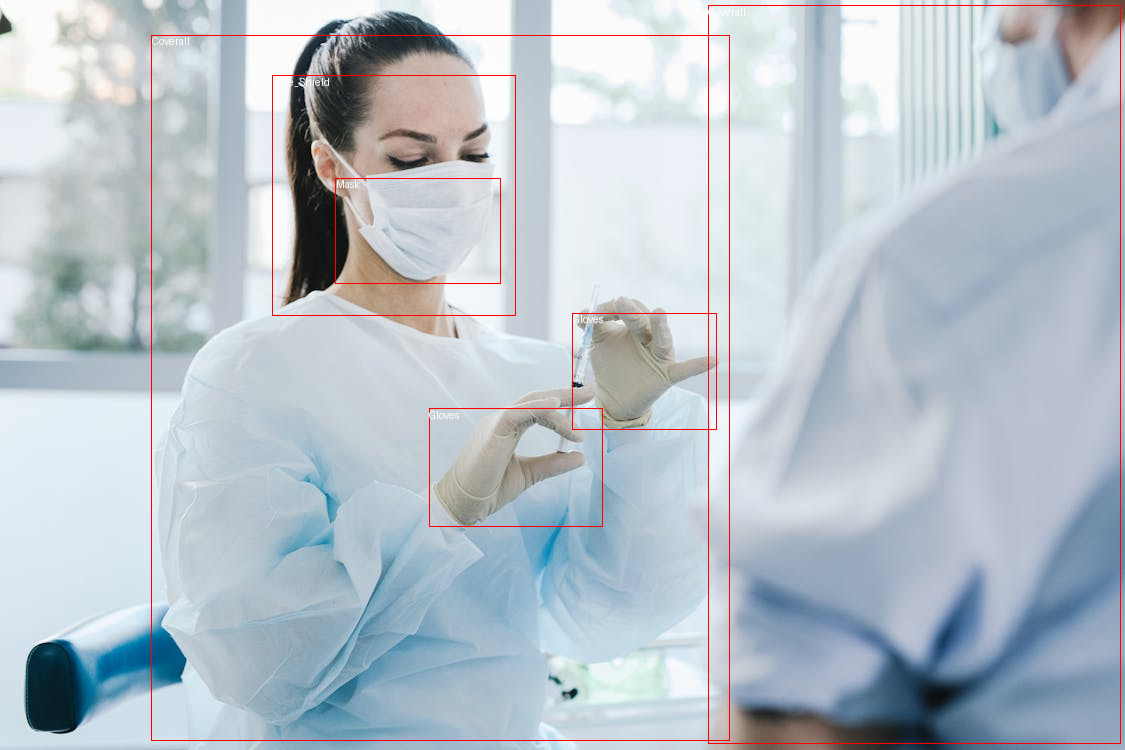

In [ ]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

<div class="flex justify-center">
    <img src="https://i.imgur.com/oDUqD0K.png" alt="Object detection result on a new image"/>
</div>